In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/hand_gesture_data/'

In [ ]:
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
%matplotlib inline

tf.random.set_seed(42) #재현을 위한 텐서플로우 seed 설정

data_train = pd.read_csv(PATH+'train.csv')
data_test = pd.read_csv(PATH+'test.csv')
print(data_train.shape)
data_train.head()

(2335, 34)


,id,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,target
0,1,-6.149463,-0.929714,9.058368,-7.017854,-2.958471,0.179233,-0.956591,-0.972401,5.956213,...,-7.026436,-6.006282,-6.005836,7.043084,21.884650,-3.064152,-5.247552,-6.026107,-11.990822,1
1,2,-2.238836,-1.003511,5.098079,-10.880357,-0.804562,-2.992123,26.972724,-8.900861,-5.968298,...,-1.996714,-7.933806,-3.136773,8.774211,10.944759,9.858186,-0.969241,-3.935553,-15.892421,1
2,3,19.087934,-2.092514,0.946750,-21.831788,9.119235,17.853587,-21.069954,-15.933212,-9.016039,...,-6.889685,54.052330,-6.109238,12.154595,6.095989,-40.195088,-3.958124,-8.079537,-5.160090,0
3,4,-2.211629,-1.930904,21.888406,-3.067560,-0.240634,2.985056,-29.073369,0.200774,-1.043742,...,-2.126170,-1.035526,2.178769,10.032723,-1.010897,-3.912848,-2.980338,-12.983597,-3.001077,1
4,5,3.953852,2.964892,-36.044802,0.899838,26.930210,11.004409,-21.962423,-11.950189,-20.933785,...,-2.051761,10.917567,1.905335,-13.004707,17.169552,2.105194,3.967986,11.861657,-27.088846,2


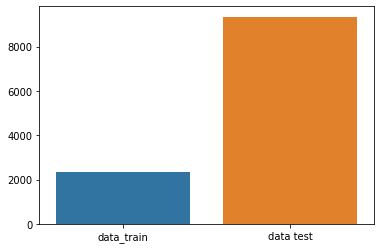

In [ ]:
x = ["data_train", "data test"]
y = [data_train.shape[0], data_test.shape[0]]
ax = sns.barplot(x=x, y=y)

In [ ]:
train_X = data_train.drop(['target', 'id'], axis = 1)
train_X = (train_X+130)/260 
train_X = np.array(train_X)
train_X = np.array(train_X).reshape(-1, 8, 4, 1)

train_Y = data_train['target']
train_Y = np.array(train_Y)

X_test = data_test.drop('id', axis = 1)
X_test = (X_test+130)/260
X_test = np.array(X_test).reshape(-1, 8, 4, 1)

In [ ]:
print("min :", train_X.min(), "\nmax :", train_X.max())

min : 0.008470580769230742 
max : 0.9890809815384616


In [ ]:
train_X.shape

(2335, 8, 4, 1)

In [ ]:
train_Y.shape

(2335,)

In [ ]:
def identity_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, (1,1), padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('gelu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('gelu')(X)
    
    X = tf.keras.layers.Conv2D(filters*4, (1,1), padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('gelu')(X)
    
    return X

In [ ]:
def convolutional_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, (1,1), padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('gelu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('gelu')(X)
    
    X = tf.keras.layers.Conv2D(filters*4, (1,1), padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)

    X_shortcut = tf.keras.layers.Conv2D(filters*4, (1,1), padding='SAME')(X_shortcut) #use 1x1 conv to make shape same
    X_shortcut = tf.keras.layers.BatchNormalization()(X_shortcut)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('gelu')(X)
    
    return X

In [ ]:
def CustomModel(input_shape = (8, 4, 1), classes = 4):
    X_input = tf.keras.layers.Input(input_shape)
    X = X_input
    
    X = convolutional_block(X, 128, (3,2)) #(3,3) 보다는 직사각형 이미지이기때문에 (3,2)처럼 직사각형 필터를 사용
    X = identity_block(X, 128, (3,2))
    X = identity_block(X, 128, (3,2))
    
    X = tf.keras.layers.AveragePooling2D(2,2)(X) #Max보다는 Average pool이 성능이 잘나옴

    X = convolutional_block(X, 256, (2,1)) #(2,1) 직사각형 필터를 사용
    X = identity_block(X, 256, (2,1))
    X = identity_block(X, 256, (2,1))
    
    X = tf.keras.layers.GlobalAveragePooling2D()(X) #Flatten 대신 사용
    
    X = tf.keras.layers.Dense(128, activation = "relu")(X)
    
    X = tf.keras.layers.Dropout(0.5)(X)
    
    X = tf.keras.layers.Dense(classes, activation = "softmax")(X)

    model = tf.keras.models.Model(inputs = X_input, outputs = X, name = "CustomModel")
    
    return model

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

skf = StratifiedKFold(n_splits = 15, random_state = 1233, shuffle = True) #총 15번의 fold 진행
n = 0 #x번째 fold인지 기록

cnn_pred = [] #모델의 예측값 모두 저장

for train_index, valid_index in skf.split(train_X, train_Y):
    n += 1
    X_train, X_valid = train_X[train_index], train_X[valid_index]
    y_train, y_valid = train_Y[train_index], train_Y[valid_index]

    ### Swap Noise ###
    X_train_mix = np.array(X_train)
    for x in range(X_train_mix.shape[0]):
        for i in range(5):
            y = np.random.randint(0, 8)
            z = np.random.randint(0, 4)
            
            while True:
                c = np.random.randint(0, X_train_mix.shape[0]-1)
                if ((x != c)and(y_train[x] == y_train[c])):
                    break
                    
            X_train_mix[x][y][z] = X_train[c][y][z]

    X_train = np.append(X_train, X_train_mix, axis = 0)
    y_train = np.append(y_train, y_train, axis = 0)
    
    ### Mix Data Again ####
    X_train, y_train = shuffle(X_train, y_train, random_state=42)
    
    y_train = tf.one_hot(y_train, 4)
    y_train = tf.reshape(y_train, [-1,4])
    y_train = np.array(y_train)
    
    y_valid = tf.one_hot(y_valid, 4)
    y_valid = tf.reshape(y_valid, [-1,4])
    y_valid = np.array(y_valid)
    
    ### Create Model ###
    model = CustomModel()
    
    ### Compile Model ###
    model.compile(optimizer='Rmsprop', # 무난한 adam 사용
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    ### Create callbacks ###
    filename = 'CNN-checkpoint.h5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filename,             # file명을 지정합니다
                                                    monitor='val_accuracy',   # val_accuracy 값이 개선되었을때 호출됩니다
                                                    verbose=1,            # 로그를 출력합니다 0일경우 출력 X
                                                    save_best_only=True,  # 가장 best 값만 저장합니다
                                                    mode='auto'           # auto는 알아서 best를 찾습니다. min/max (loss->min, accuracy->max)
                                                   )
    earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',  # 모니터 기준 설정 (val loss) 
                                  patience=12,         # 12 Epoch동안 개선되지 않는다면 종료
                                 )
    reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy', # val_accuracy 값이 개선되었을때 호출됩니다
        factor=0.5, # learning rate이 0.5배 줄어듬
        patience=6, # 6 Epoch동안 개선되지 않는다면 호출
    )
    
    ### fit model ###
    data = model.fit(X_train, 
                     y_train, 
                     validation_data=(X_valid, y_valid), 
                     epochs=60, 
                     batch_size=32, # batch size가 32일때 가장 좋은 성능을 보임
                     callbacks=[reduceLR, earlystopping, checkpoint],
                     verbose=1 # 로그 출력을 없앰, 어짜피 아래 print에서 한번에 best_accuracy만 출력할것이기 때문이다.
                    )
    
    idx = data.history['val_accuracy'].index(max(data.history['val_accuracy']))
    
    print("fold %d / val_accuracy : %0.4f / val_loss : %0.4f" %(n,
                                                                data.history['val_accuracy'][idx], 
                                                                data.history['val_loss'][idx]))
    
    ### predict model ###
    model = tf.keras.models.load_model('./CNN-checkpoint.h5') # best accuracy를 기록한 모델을 불러옴
    pred_proba = model.predict(X_test) # 테스트 셋에 대한 예측 수행
    cnn_pred.append(pred_proba) # 예측값을 cnn_pred 리스트에 저장

Epoch 1/60
136/137 [============================>.] - ETA: 0s - loss: 1.1327 - accuracy: 0.6055
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to CNN-checkpoint.h5
137/137 [==============================] - 15s 46ms/step - loss: 1.1317 - accuracy: 0.6058 - val_loss: 1.8751 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/60
137/137 [==============================] - ETA: 0s - loss: 0.6152 - accuracy: 0.7806
Epoch 2: val_accuracy did not improve from 0.33333
137/137 [==============================] - 5s 37ms/step - loss: 0.6152 - accuracy: 0.7806 - val_loss: 2.6599 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 3/60
137/137 [==============================] - ETA: 0s - loss: 0.5155 - accuracy: 0.8157
Epoch 3: val_accuracy improved from 0.33333 to 0.45513, saving model to CNN-checkpoint.h5
137/137 [==============================] - 5s 39ms/step - loss: 0.5155 - accuracy: 0.8157 - val_loss: 2.0398 - val_accuracy: 0.4551 - lr: 0.0010
Epoch 4/60
137/137 [============================

In [ ]:
pred_proba = cnn_pred[0]
pred_proba = np.array(pred_proba)
print(pred_proba[0])

for x in range(1, 15):
    pred_proba += cnn_pred[x]
    print(cnn_pred[x][0])

pred_class = []

for i in pred_proba:
    pred = np.argmax(i)
    pred_class.append(pred)

[1.0000000e+00 3.8862729e-11 1.2182455e-09 2.4991947e-10]
[9.9999988e-01 1.3635090e-09 3.2203697e-08 5.4746806e-08]
[9.9999964e-01 2.9515110e-07 1.5564758e-08 1.1760403e-07]
[9.9999917e-01 1.1761632e-07 7.0937398e-07 1.0406036e-09]
[9.9999082e-01 4.4541046e-08 3.3078511e-08 9.1409993e-06]
[1.0000000e+00 4.1992247e-12 3.5888102e-11 2.7059099e-10]
[9.9998295e-01 1.1434765e-06 1.4482791e-05 1.3308984e-06]
[9.9999738e-01 4.5476309e-10 2.6673918e-06 1.0789051e-10]
[9.9863619e-01 1.2927447e-05 1.3496318e-03 1.1349587e-06]
[1.0000000e+00 9.5521342e-09 2.2710593e-10 2.3098019e-08]
[1.0000000e+00 5.6799578e-12 4.6634937e-14 4.3602402e-10]
[9.9997103e-01 7.1018655e-07 2.7927375e-05 2.6690222e-07]
[9.9996877e-01 4.0141013e-06 2.7032042e-05 1.2837310e-07]
[9.9529159e-01 5.2525662e-04 3.8719545e-03 3.1127414e-04]
[9.9999988e-01 4.5063347e-10 5.4875184e-08 2.0691900e-08]


In [ ]:
import pandas as pd

sample_submission = pd.read_csv(PATH+"sample_submission.csv")

sample_submission.target = pred_class
sample_submission.to_csv(PATH+"submit_짱짱걸1.csv",index=False)

In [ ]:
sample_submission.head()

,id,target
0,1,0
1,2,0
2,3,1
3,4,3
4,5,2
